In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


## Chi2-tests

Stats textbooks say that the chi2 test statistic under the null hypothesis follows [such and such distribution](https://en.wikipedia.org/wiki/Chi-square_distribution), but it would be nice to confirm this with actual data and see it with our own eyes. We can simulate a lot of random experiments, run a chi2 test on each of them, look at the resulting distribution and compare it to the analytical formula.

Let's implement a simple 2x2 chi2 test function called `manual_chi2`. Its input should be two lists, one with observations for condition 1, and another one with corresponding observations for condition 2. The values of the lists can be boolean, `True` if the individual is positive for the condition, and `False` otherwise.

The function's usage will be like `manual_chi2([True, True, False, True, False], [False, True, True, False, False])`.

In [2]:
def manual_chi2(cond1, cond2):
    # simple 2x2 chi2 test
    # cond1 and cond2 are expected to be lists of 1/0 or True/False values.

    N = len(cond1)
    p1 = sum(cond1)/N  # proportion of individuals positive for condition 1
    p2 = sum(cond2)/N  # proportion of individuals positive for condition 2
    
    # we know that the absolute difference between expected and observed is the same for
    # every cell of a simple 2x2 contingency table (this is why it's said to have 1 degree of freedom)
    # so we can choose any cell (say, positive for both) to determine this difference.
    # We don't really have to build the entire contingency table.
    
    expected_11 = p1 * p2 * N  # p1*p2*N expected to be positive for both conditions
    actual_11 = sum(1 for x1, x2 in zip(cond1, cond2) if x1 and x2)  # list comprehension with a condition
    diff = actual_11 - expected_11
    
    # We do have to calculate all expected value cells though, they're N*p1*p2, N*(1-p1)*p2, etc.
    chi2 = diff**2 * (1/(p1*p2) + 1/((1-p1)*p2) + 1/(p1*(1-p2)) + 1/((1-p1)*(1-p2))) / N
    
    return chi2

Now we can run the simulation. Each "experiment" should be using a random sized population with random probabilites for the two conditions. We want to perform the simulation under the null hypothesis (no association between the conditions) which is easy to guarantee if we generate the condition lists separately and randomly.

In [3]:
chi2_values = []
for i in range(10000):
    N = np.random.randint(100, 1000)  # define a random sized population
    p1 = np.random.uniform(0.1, 0.9)  # pick a random probability for condition 1
    p2 = np.random.uniform(0.1, 0.9)  # pick a random probability for condition 2
    cond1 = (np.random.random(N) < p1)  # generate N random condition 1 values (True/False) with probability p1 for True
    cond2 = (np.random.random(N) < p2)  # generate N random condition 2 values (True/False) with probability p2 for True
    chi2 = manual_chi2(cond1, cond2)  # run chi2 test, obtain the test statistic
    chi2_values.append(chi2)  # store the chi2 test statistic

We have generated 10,000 association experiments under the null hypothesis, and performed a chi2 test on all of them. Now we can look at the distribution of chi2 values. We will display them on a histogram, and we will also plot the theoretical 1-degree-of-freedom chi2 probability density function on top of it for comparison.

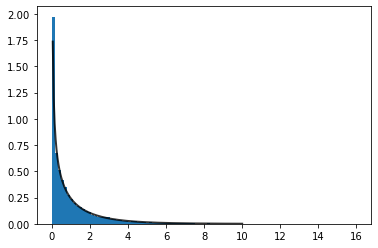

In [4]:
# histogram of the chi2 test statistics
plt.hist(chi2_values, bins=100, density=True);

# line plot of the theoretical distribution
x = np.linspace(0, 10, 200)
plt.plot(x, scipy.stats.chi2(1).pdf(x), linewidth=2, color='black', alpha=0.8)

We could also make an alternative plot with the cumulative distributions. It isn't really necessary here, but it's useful when the test statistics have discrete peaks due to small sample counts or other effects like limited population size.

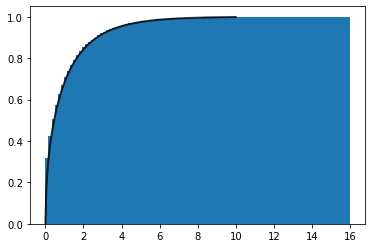

In [5]:
# Cumulative distributions (more useful when the test statistic has discrete "peaks"):
plt.hist(chi2_values, bins=100, density=True, cumulative=True);
plt.plot(x, scipy.stats.chi2(1).cdf(x), linewidth=2, color='black', alpha=0.8)

We have verified that under the null hypothesis, the test statistic distribution matches the theoretical chi2 distribution. The textbooks didn't lie.

The cool thing is that even if we hadn't known the analytical form of the chi2 distribution, we could have created a good approximation of it via simulation. That would be called bootstrapping.

Usually we prefer to convert test statistics (in this case, the chi2 values) into p-values. A chi2 value of, say, 3.5 isn't too informative on its own, but the corresponding p-value (0.061) has a clear meaning: there's a 6.1% chance of getting a test statistic result larger than 3.5 under the null hypothesis (i.e. due to random chance).

So if we want to convert a test statistic `s` into a p-value `p`, we have to check out what proportion of the test statistic distribution is above `s`. The CDF of a distribution tells you the proportion below `s`, therefore `p = 1 - cdf(s)`. This is sometimes called the "survival function", so `p = 1 - cdf(s) = sf(s)`.

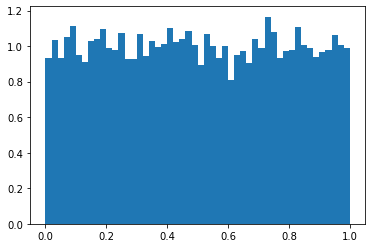

In [6]:
# let's convert chi2 values to p-values:
p_values = 1 - scipy.stats.chi2(1).cdf(chi2_values)  # or scipy.stats.chi2(1).sf(chi2_values)

# Display them on a histogram:
plt.hist(p_values, bins=50, density=True);

This is indeed a uniform p-value distribution between 0 and 1, which is the expected behaviour of any well-calibrated and appropriate statistical test under the null hypothesis.

From now on, we will not bother with looking at test statistics, or convert them manually into p-values. Every statistical test in `scipy.stats` can do the necessary conversions and return p-values directly. Hopefully you now have a better understanding of how they are produced.

And always remember: the p-value distribution *under the null hypothesis* (i.e. assuming no effect) should be uniform. Deviations from this uniform distribution (especially towards the interesting near-0 region) can either suggest a real effect, or a poorly designed experiment / inappropriate statistical test.